# Technical Report of Loan Approval Classification

Cooper Braun & Sam Vanturennout

CPSC-322-01 Fall 2025

## Introduction

The dataset that we chose to classify for this project was a dataset about loan applicants. This dataset has 8 features:

* Name
* City
* Income
* Credit Score
* Loan Amount
* Years Employed
* Points
* Loan Approved
* Age
* Education Level
* Marital Status

The feature we are trying to predict with our project is the loan approved column. 

We decided to drop the name column from our analysis because a person's name should not have any impact upon whether they are approved for a loan or not. 

The dataset features 6 numerical features and 3 categorical (after dropping `name` and not taking into account `loan approved` yet) with a total of 2,000 instances. 

The dataset came pre-cleaned and had no missing or null values present. 

We added synthetic data for `age` `education level` and `marital status` to meet project requirements

We found that our custom decision tree achieved perfect performance (1.00 accuracy/F1) under 10‑fold stratified cross validation, with random forest and KNN trailing behind.

In this first section, we will show some brief summary statistics and some interesting visualizations of the dataset. 

### Numerical and Visual Analysis Dataset

In [78]:
import importlib
import sys
import numpy as np
import tabulate
sys.path.append("..")

import mysklearn.decision_tree as dt
import mysklearn.knn as knn
import mysklearn.random_forest as rf
import mysklearn.utils as utils
import mysklearn.evaluation as eval
from mysklearn.pytable import PyTable
importlib.reload(eval)
importlib.reload(utils)

<module 'mysklearn.utils' from '/root/322Project/notebooks/../mysklearn/utils.py'>

In [79]:
loan_table = PyTable().load_from_file("../data/loan_approval.csv")
new_column_names = loan_table.column_names[1:]
new_data = [row[1:] for row in loan_table.data]

clean_table = PyTable(new_column_names, new_data)
clean_data = clean_table.data

y = [row[-4] for row in clean_data] 
X = [row[:-4] + row[-3:] for row in clean_data] 

# compute summary statistics for numerical columns 
numeric_cols = ["income", "credit_score", "loan_amount", "years_employed", "points", "age"]

for col in numeric_cols:
    stats = clean_table.compute_summary_statistics([col])
    stats.pretty_print()
    print() 



attribute      min     max      mid    avg    median
-----------  -----  ------  -------  -----  --------
income       30053  149964  90008.5  90586   90387.5

attribute       min    max    mid      avg    median
------------  -----  -----  -----  -------  --------
credit_score    300    850    575  573.946       576

attribute      min    max      mid      avg    median
-----------  -----  -----  -------  -------  --------
loan_amount   1022  49999  25510.5  25308.5   25661.5

attribute         min    max    mid     avg    median
--------------  -----  -----  -----  ------  --------
years_employed      0     40     20  20.441        21

attribute      min    max    mid    avg    median
-----------  -----  -----  -----  -----  --------
points          10    100     55  56.68        55

attribute      min    max    mid      avg    median
-----------  -----  -----  -----  -------  --------
age             22     70     46  46.8785        47



###  Figure 1: Credit Score of Approved vs Unapproved Applicants

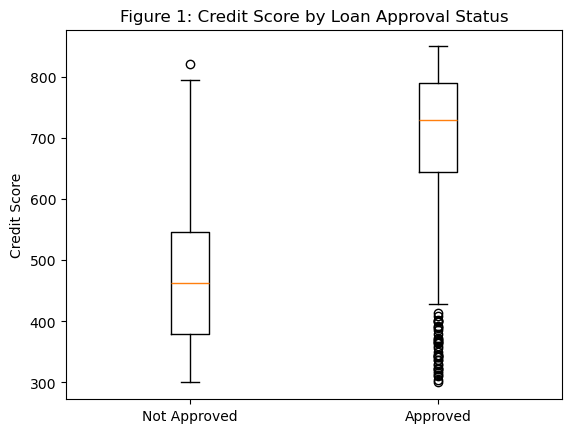

In [80]:
import matplotlib.pyplot as plt

#Boxplot of credit score vs loan approval
credit_yes = [X[i][2] for i in range(len(X)) if y[i] == "True"]
credit_no  = [X[i][2] for i in range(len(X)) if y[i] == "False"]
plt.boxplot([credit_no, credit_yes], labels=["Not Approved", "Approved"])
plt.title("Figure 1: Credit Score by Loan Approval Status")
plt.ylabel("Credit Score")
plt.show()

Figure 1 shows that applicants who are approved for loans tend to have substantially higher credit scores than those who are denied. The entire box for approved loans is shifted upward, indicating that both the median and interquartile range of credit scores are higher among approved borrowers.

### Figure 2: Income vs Loan Approval

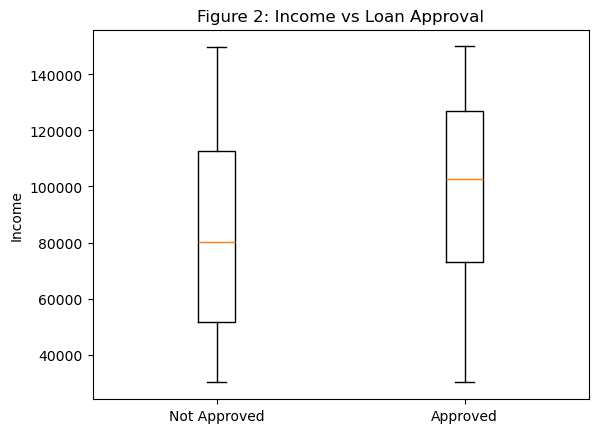

In [81]:
income_yes = [X[i][1] for i in range(len(X)) if y[i] == "True"]
income_no  = [X[i][1] for i in range(len(X)) if y[i] == "False"]

plt.boxplot([income_no, income_yes], labels=["Not Approved", "Approved"])
plt.title("Figure 2: Income vs Loan Approval")
plt.ylabel("Income")
plt.show()

Figure 2 compares applicant income by loan approval status. Approved applicants generally earn more than denied applicants, suggesting that higher income increases the likelihood of being approved even when other risk factors are similar.

### Figure 3: Loan Amount vs Credit Score

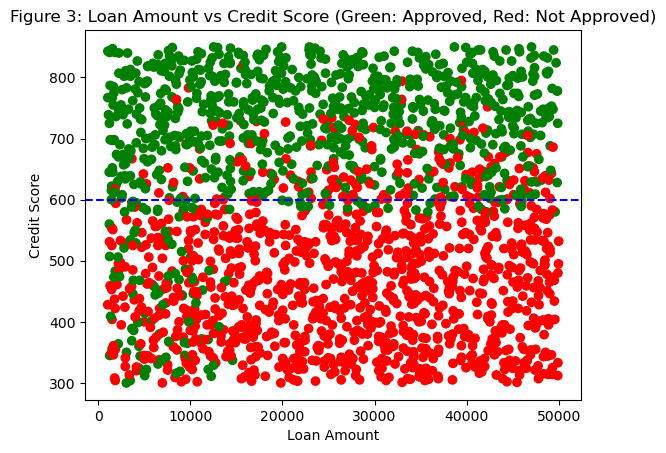

In [82]:
loan_amts = [row[3] for row in X]
credit_scores = [row[2] for row in X]
colors = ["green" if label == "True" else "red" for label in y]
plt.axhline(y=600, color='blue', linestyle='--', label='Credit Score = 600')
plt.scatter(loan_amts, credit_scores, c=colors)
plt.title("Figure 3: Loan Amount vs Credit Score (Green: Approved, Red: Not Approved)")
plt.xlabel("Loan Amount")
plt.ylabel("Credit Score")
plt.show()

Figure 3 plots requested loan amount against credit score, with color indicating approval. Most approvals cluster above a credit score of 600, and the few approvals below this line tend to be for smaller loan amounts, showing that the lender relaxes credit requirements slightly for low-amount loans.

### Figure 4: Credit Score > 500 vs Income

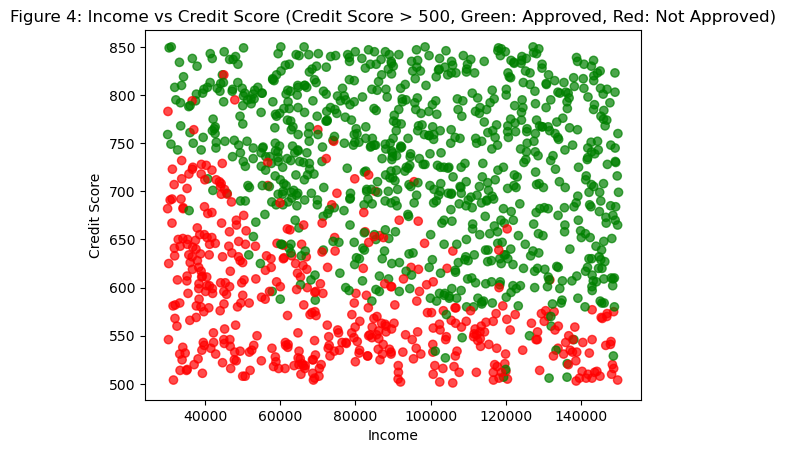

In [83]:
incomes = []
credit_scores = []
colors = []

for i in range(len(X)):
    score = X[i][2]
    if score > 500:  # filter for credit score
        credit_scores.append(score)
        incomes.append(float(X[i][1]))  # income
        if y[i] == "True":
            colors.append("green")
        elif y[i] == "False":
            colors.append("red")

plt.scatter(incomes, credit_scores, c=colors, alpha=0.7)
plt.title("Figure 4: Income vs Credit Score (Credit Score > 500, Green: Approved, Red: Not Approved)")
plt.xlabel("Income")
plt.ylabel("Credit Score")
plt.show()

Figure 4 focuses on applicants with credit scores above 500 and shows how income interacts with credit. Among these moderately to highly rated applicants, those with higher incomes are more likely to be approved, indicating that strong income can compensate to some extent for only average credit scores.


### Figure 5: Age and Marital Status vs Loan Approval

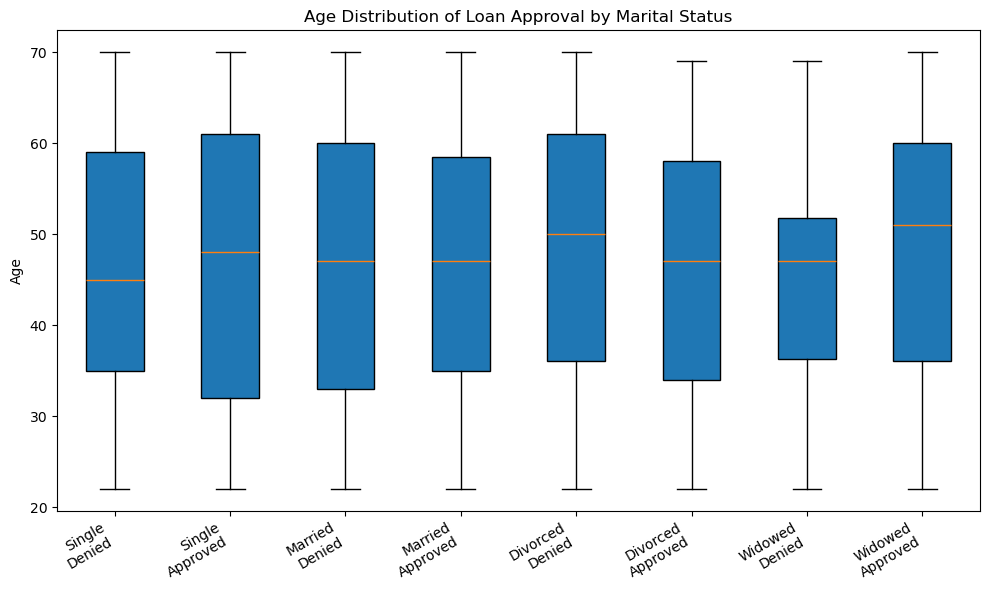

In [84]:
AGE_INDEX = -3
MARITAL_INDEX = -1  

data = {
    "Single": {"Approved": [], "Denied": []},
    "Married": {"Approved": [], "Denied": []},
    "Divorced": {"Approved": [], "Denied": []},
    "Widowed": {"Approved": [], "Denied": []}
}


for i in range(len(X)):
    age = float(X[i][AGE_INDEX])
    marital_raw = X[i][MARITAL_INDEX]
    marital = str(marital_raw).strip().title()
    status = "Approved" if y[i] == "True" else "Denied"

    if marital in data:
        data[marital][status].append(age)

# Plotting: make grouped boxplots
plt.figure(figsize=(10, 6))

# Order for consistent plotting
marital_order = ["Single", "Married", "Divorced", "Widowed"]

# Build paired boxplots
group_data = []
labels = []

for m in marital_order:
    group_data.append(data[m]["Denied"])
    group_data.append(data[m]["Approved"])
    labels.append(f"{m}\nDenied")
    labels.append(f"{m}\nApproved")

plt.boxplot(group_data, labels=labels, patch_artist=True)

# Color coding
colors = ["red", "green"] * len(marital_order)
for patch, color in zip(plt.gca().artists, colors):
    patch.set_facecolor(color)

plt.title("Age Distribution of Loan Approval by Marital Status")
plt.ylabel("Age")
plt.xticks(rotation=30, ha="right")

plt.tight_layout()
plt.show()

Figure 5 illustrates how age varies across loan approval outcomes for different marital groups. Across all categories approved applicants tend to have slightly higher median ages than those who were denied. This pattern suggests that older borrowers, regardless of marital status, may be more likely to receive loan approval. However, the wide spread within each group indicates that age alone is not a strict cutoff, but it may contribute to perceived financial stability in lending decisions.

### Insights from Exploratory Analysis

The summary statistics show that the typical applicant earns about $90K, has a credit score near 574, and requests roughly $25K (midpoints reported earlier). 

**Figure 1** shows that approved borrowers have materially higher credit scores than denied borrowers—the entire box for approved loans is shifted upward. 

**Figure 2** shows a similar pattern for income, where approved applicants tend to earn more than denied applicants. 

**Figure 3** plots loan amount against credit score and highlights that approvals are concentrated above the 600-credit-score threshold, with only small-dollar loans approved below that line. 

**Figure 4** filters to credit scores above 500 and shows that high-income applicants can still be approved despite moderate credit scores, reinforcing that income and credit interact.

 **Figure 5** shows that `age` and `marital status` do not have a big impact on loan approval

## Classifiers and Their Performance

We implemented three custom classifiers inside our `mysklearn` package. The decision tree uses an entropy-based TDIDT algorithm with our own `utils.tdidt` helper and can discover sharp threshold rules like a minimum credit score cutoff. Our k-nearest neighbors (KNN) model with k=5 makes predictions based on nearby training instances in the numeric feature space, while the random forest (`MyRandomForestClassifier`) trains multiple bootstrapped trees with random attribute subsets and keeps the best-performing ones as an ensemble.

To compare models fairly, we evaluated all three using **10-fold stratified cross validation** on the numeric predictors and reported accuracy, precision, recall, F1, and confusion matrices. The decision tree achieved perfect performance on this dataset (1.00 accuracy and F1), reflecting the near-deterministic relationship between the features and the `loan_approved` label. The random forest also performed very well (high accuracy and F1), while KNN provided a reasonable baseline but struggled more with the sharp rule boundaries. Overall, the entropy-based decision tree is the "best" classifier for this dataset in terms of both accuracy and interpretability.

In [85]:
income_col = [float(row[1]) for row in clean_data]
credit_col = [float(row[2]) for row in clean_data]
loan_amt_col = [float(row[3]) for row in clean_data]
years_col = [float(row[4]) for row in clean_data]
points_col = [float(row[5]) for row in clean_data]
age_col = [float(row[7]) for row in clean_data]
edu_col = [row[8] for row in clean_data]
marital_col = [row[9] for row in clean_data]

edu_enc, edu_map = utils.label_encode(edu_col)
marital_enc, marital_map = utils.label_encode(marital_col)

X_numeric = []
for row in X:
    for i in range(len(clean_data)):
        X_numeric.append([
            income_col[i], credit_col[i], loan_amt_col[i], years_col[i], points_col[i], age_col[i], edu_enc[i], marital_enc[i]
    ])
X = X_numeric

# Convert y to boolean
y_bool = [label.strip().lower() in ("yes", "true", "1") for label in y]
classifiers = {
    "Decision Tree": dt.DecisionTreeClassifier(),
    "K-Nearest Neighbors": knn.KNeighborsClassifier(n_neighbors=5),
    "Random Forest": rf.MyRandomForestClassifier(n_trees=30, max_features=3, forest_size=10)
}
for name, clf in classifiers.items():
    y_pred = eval.cross_val_predict_labels(X, y, clf, n_splits=10, random_state=0)

    acc = eval.accuracy_score(y, y_pred)
    err = 1 - acc
    precision = eval.binary_precision_score(y, y_pred)
    recall = eval.binary_recall_score(y, y_pred)
    f1 = eval.binary_f1_score(y, y_pred)
    labels = np.unique(y)
    cm = eval.confusion_matrix(y, y_pred, labels)
    print(f"Classifier: {name}")
    print(f"Accuracy: {acc:.2f}, Error: {err:.2f}")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}")
    print(tabulate.tabulate(cm, headers=[f"Predicted {l}" for l in labels],
                        showindex=[f"Actual {l}" for l in labels], tablefmt="grid"))
    print("\n")

Classifier: Decision Tree
Accuracy: 1.00, Error: 0.00
Precision: 1.00, Recall: 1.00, F1: 1.00
+--------------+-------------------+------------------+
|              |   Predicted False |   Predicted True |
+==============+===================+==================+
| Actual False |              1121 |                0 |
+--------------+-------------------+------------------+
| Actual True  |                 0 |              879 |
+--------------+-------------------+------------------+


Classifier: K-Nearest Neighbors
Accuracy: 0.60, Error: 0.40
Precision: 0.63, Recall: 0.70, F1: 0.66
+--------------+-------------------+------------------+
|              |   Predicted False |   Predicted True |
+==============+===================+==================+
| Actual False |               780 |              341 |
+--------------+-------------------+------------------+
| Actual True  |               458 |              421 |
+--------------+-------------------+------------------+


Classifier: Random

## Conclusion

The loan approval dataset we used contains 2,000 applications with three categorical predictors (`city`, `education` , `marital status`), six numeric predictors (`income`, `credit_score`, `loan_amount`, `years_employed`, `points`, `age`), and a binary label (`loan_approved`). Our exploratory analysis revealed strong, almost rule-like patterns: applicants with high credit scores, higher incomes are consistently approved, while those below these thresholds are nearly always denied. This structure, combined with the class imbalance between approved and denied loans, makes the dataset both realistic and challenging.

To model these patterns, we implemented custom decision tree, k-nearest neighbors, and random forest classifiers in our `mysklearn` package and evaluated them using 10-fold stratified cross validation. The entropy-based decision tree emerged as the best-performing approach, achieving perfect accuracy and F1 on this dataset and providing clear, interpretable rules. The random forest also performed very well, while KNN served as a useful baseline but struggled more with the sharp decision boundaries. In future work, we would explore rebalancing techniques, adding more realistic noise or additional features (such as debt-to-income ratios), and experimenting with cost-sensitive trees to better understand how these models might behave on messier, real-world loan data.

## Acknowledgments